Notebook accompanying the paper

Note that this notebook requires installing: pysteps, matplotlib, cartopy

In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import pickle
import numpy as np
from scipy.stats import pearsonr
from scipy.ndimage import uniform_filter

from string import ascii_lowercase
import matplotlib.pyplot as plt
from matplotlib import colors, gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature


latitude_range = np.arange(-11.95, 15.95, 0.1)
longitude_range = np.arange(25.05, 49.05, 0.1)



## Plots of correlation and FSS

In [26]:
def get_convolved_fractions(array: np.ndarray, threshold: float, scale: int, mode='constant'):
    """
    Applies a threshold to data and a convolution filter

    Args:
        array (np.ndarray): Array of data
        threshold (float): Rainfall threshold
        scale (int): Width of filter

    Returns:
        np.ndarray: Filtered array
    """
    if len(array.shape) == 2:
        array = np.expand_dims(array, axis=0)
    
    binary_array = (array >= threshold).astype(np.single)
    
    convoluted_array = np.empty(shape=array.shape)
    
    if scale > 1:
        for n in range(array.shape[0]):
            # Performing this in a loop since older versions
            # of uniform_filter do not accept the axes parameter
            
            if mode == 'constant':
                convoluted_array[n,...] = uniform_filter(binary_array[n,...], 
                                                size=scale, 
                                                mode="constant", 
                                                cval=0.0)
            else:
                convoluted_array[n,...] = uniform_filter(binary_array[n,...], 
                                                size=scale, 
                                                mode=mode)
    else:
        convoluted_array = binary_array
            
    return convoluted_array

def theoretical_fss(mu_obs, mu_f, sigma_obs, sigma_f, rho):
    
    A = (2*mu_obs*mu_f)/(mu_obs**2 + mu_f**2 + sigma_obs**2 + sigma_f**2)
    
    return A  + 2 *(rho * sigma_f * sigma_obs) / (mu_obs**2 + mu_f**2 + sigma_obs**2 + sigma_f**2)

def fss_random_bound(mu_obs, sigma_obs, mu_obs_0, neighbourhood_width, mode='constant'):

    if mode =='constant':
        padding_factor = mu_obs/mu_obs_0
        sigma_bernoulli_sqd = (1/neighbourhood_width**2)*(padding_factor*mu_obs_0 - (padding_factor**2)*(mu_obs_0**2) )
    else:
        sigma_bernoulli_sqd = (1/neighbourhood_width**2)*(mu_obs_0 - mu_obs_0**2)
    
    sigma_fcst = np.sqrt(sigma_bernoulli_sqd)
    
    return theoretical_fss(mu_obs=mu_obs, mu_f=mu_obs, sigma_obs=sigma_obs, sigma_f=sigma_fcst, rho=0)

lake_feature = cfeature.NaturalEarthFeature(
    'physical', 'lakes',
    cfeature.auto_scaler, edgecolor='black', facecolor='never')

def plot_contourf( data, title, lon_range, lat_range, ax=None, value_range=None,
                  cmap='Reds', extend: str='both'):
    
    
    if value_range is not None:
        im = ax.contourf(lon_range, lat_range, data, transform=ccrs.PlateCarree(),
                            cmap=cmap, 
                            levels=value_range, norm=colors.Normalize(min(value_range), max(value_range)),
                            extend=extend)
    else:

        im = ax.contourf(lon_range, lat_range, data, transform=ccrs.PlateCarree(),
                    cmap=cmap, 
                    extend=extend)

    ax.coastlines(resolution='10m', color='black', linewidth=0.4)
    
    ax.add_feature(lake_feature, alpha=0.4)
    ax.set_title(title)
    
    return im


In [30]:
with open('examples.pkl', 'rb') as ifh:
    examples = pickle.load(ifh)

legend_pos = ['lower right',
              'center right',
              'lower right',
              'lower right',
              'lower right', 
              'upper right',
              'lower right',
              'upper right',
              'upper center'
            ]

/var/folders/v4/9hznb5s5563242xcz40z0xl40000gn/T/ipykernel_11320/2416023227.py:22: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=4)


fss_3_20_2019_hr8-14_thr90_mode-reflect.pdf
fss_3_15_2019_hr18-24_thr90_mode-reflect.pdf
fss_3_1_2019_hr0-6_thr90_mode-reflect.pdf
fss_3_1_2019_hr18-24_thr90_mode-reflect.pdf
fss_3_16_2019_hr18-24_thr90_mode-reflect.pdf
fss_4_16_2019_hr0-6_thr90_mode-reflect.pdf
fss_4_17_2019_hr18-24_thr90_mode-reflect.pdf
fss_5_31_2019_hr0-6_thr90_mode-reflect.pdf
fss_5_14_2019_hr6-12_thr90_mode-reflect.pdf


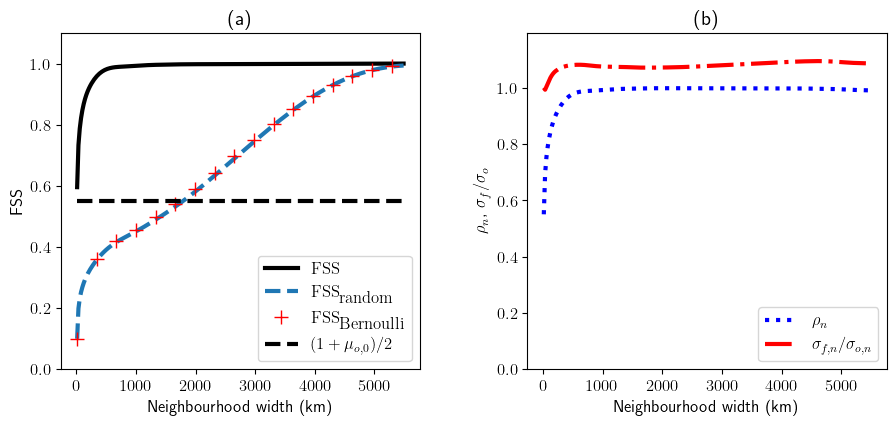

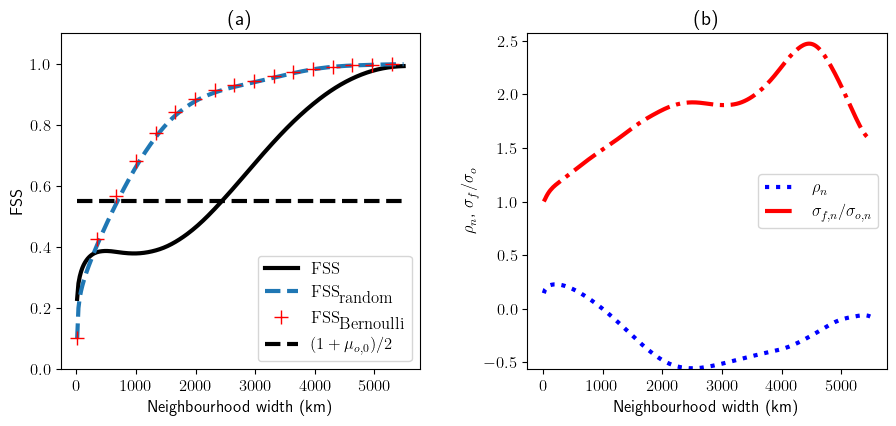

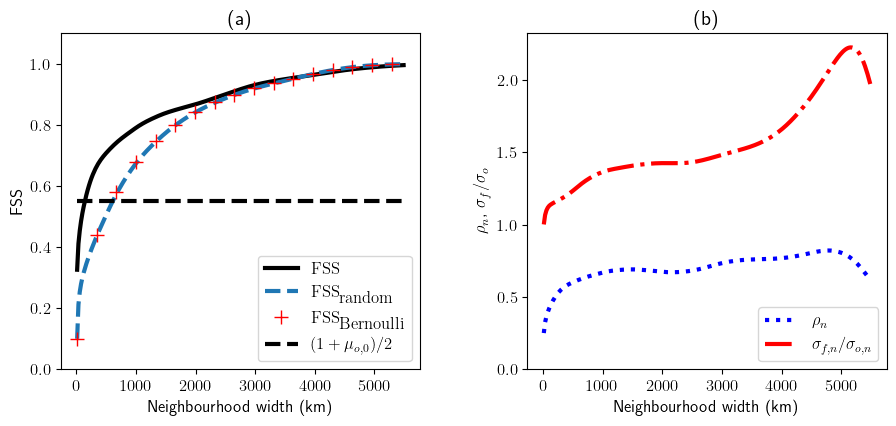

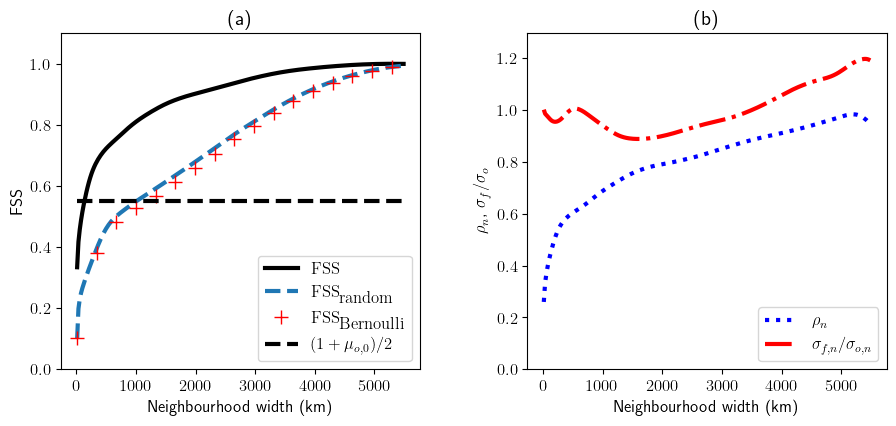

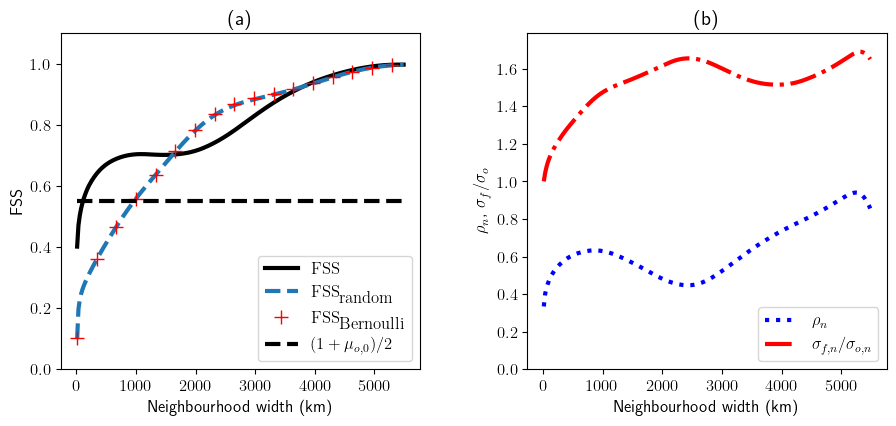

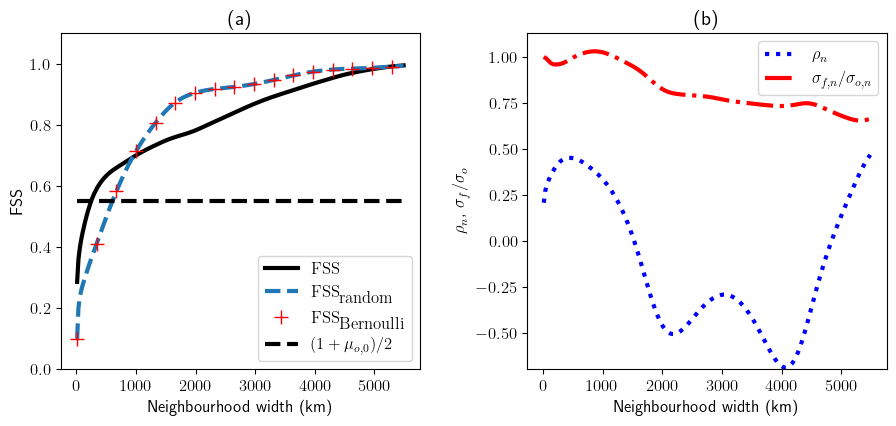

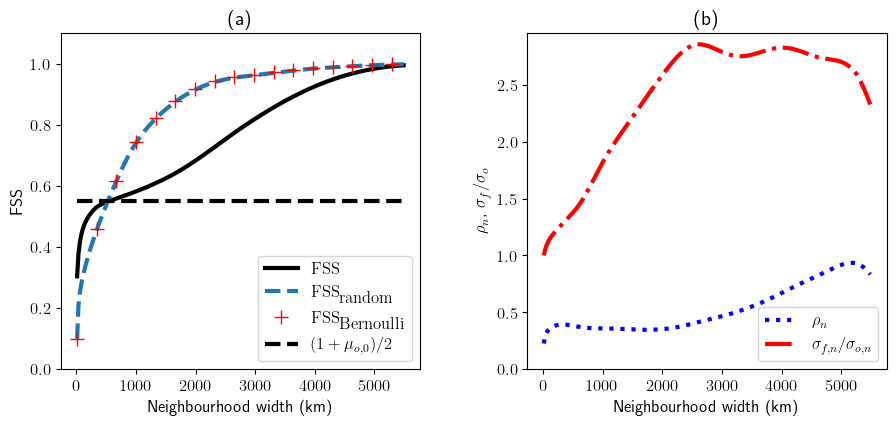

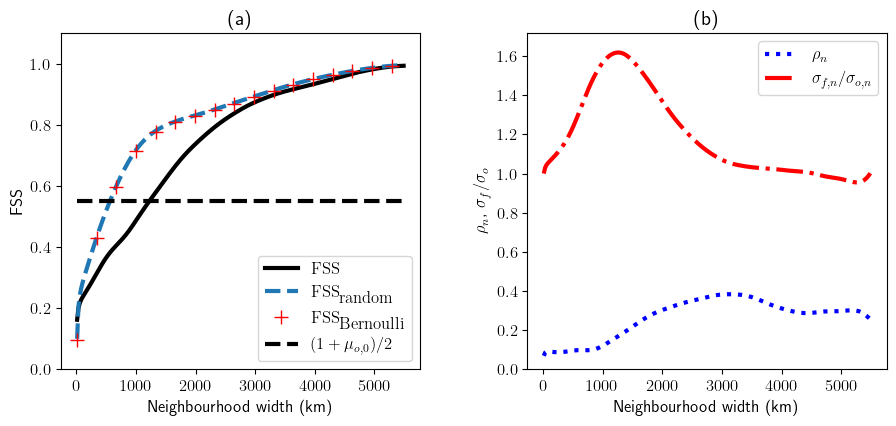

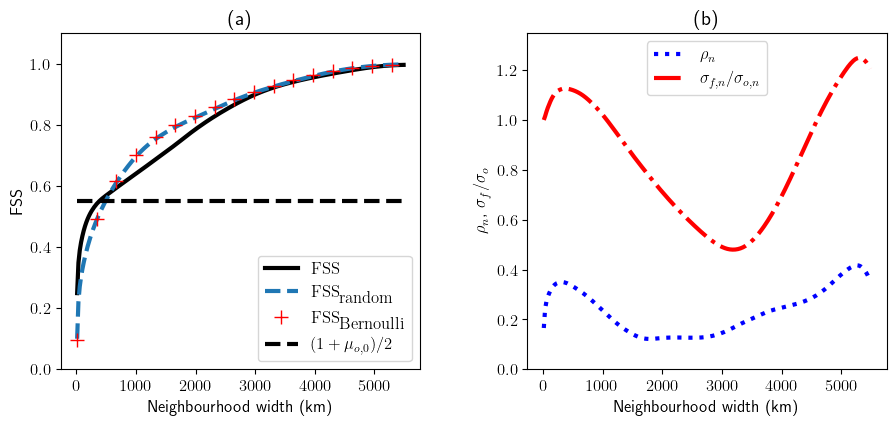

In [31]:
import string
all_letters = string.ascii_lowercase

plt.rcParams.update({'font.size': 12})
plt.rcParams['text.usetex'] = True

percentile_threshold = 90
n_range = range(0,250)
bernoulli_n_range = np.arange(0,250, 10)
km_per_grid_sq = 11
window_width_range = [km_per_grid_sq*(2*n+1) for n in n_range]
linewidth=3
year_of_data = 2019
mode = 'reflect'
num_random_iterations = 2

letter_number = 0

for ex_no, example in enumerate(examples):

    fig, axs = plt.subplots(1,2, figsize=(10,5), constrained_layout=True)
    fig.tight_layout(pad=4)
    
    hr_start = example['hr_start']
    hr_end = example['hr_end']
    day=example['day']
    month=example['month']

    corr_results= {}

    X_o = example['obs']
    X_f = example['forecast']
    
    N_x, N_y = X_o.shape

    forecast_threshold = np.percentile(X_f[:,:], percentile_threshold)
    obs_threshold = np.percentile(X_o[:,:], percentile_threshold)
    f0 = (X_o > obs_threshold).mean()
    
    S_f = [get_convolved_fractions(array=X_f[:,:], threshold=forecast_threshold, scale=2*n+1, mode=mode) for n in n_range]
    S_o = [get_convolved_fractions(array=X_o[:,:], threshold=obs_threshold, scale=2*n+1, mode=mode) for n in n_range]

    fcst_mu = [item.mean() for item in S_f]
    fcst_sigma = [item.std() for item in S_f]

    obs_mu = [item.mean() for item in S_o]
    obs_sigma = [item.std() for item in S_o]

    
    rho = [pearsonr(S_f[ii].flatten(), S_o[ii].flatten()).statistic for ii in range(len(n_range))]

    mu_bias = [fcst_mu[ii] / obs_mu[ii] for ii in range(len(n_range))]
    sigma_bias = [fcst_sigma[ii] / obs_sigma[ii] for ii in range(len(n_range))]

    fss_results = [theoretical_fss(obs_mu[ii], fcst_mu[ii], obs_sigma[ii], fcst_sigma[ii], rho[ii]) for ii in range(len(n_range))]

    # Calculate Bernoulli FSS
    bernoulli_array = np.random.binomial(1, f0, size=(N_x, N_y)).astype(np.float64)
    S_b = [get_convolved_fractions(array=bernoulli_array[:,:], threshold=0.5, scale=2*n+1, mode=mode) for n in n_range]

    rho_b = [pearsonr(S_b[ii].flatten(), S_o[ii].flatten()).statistic for ii in range(len(n_range)) ]
    bern_mu = [item.mean() for item in S_b]
    bern_sigma = [item.std() for item in S_b]
    fss_results_bern = [theoretical_fss(obs_mu[ii], bern_mu[ii], obs_sigma[ii], bern_sigma[ii], rho_b[ii]) for ii in range(len(n_range))]

    random_bound = [fss_random_bound(mu_obs=obs_mu[ii], sigma_obs=obs_sigma[ii], mu_obs_0=obs_mu[ii], neighbourhood_width=(2*n_range[ii]+1), mode=mode) for ii in range(len(n_range))]

    
    axs[0].plot(window_width_range, fss_results, label=r'$\textrm{FSS}$', linewidth=linewidth, color='k')
    axs[0].plot(window_width_range, random_bound, linewidth=linewidth, linestyle='--', label=r'$\textrm{FSS}_{\textrm{random}}$')
    # axs[0].plot(window_width_range, persistence_bound, linewidth=linewidth, linestyle='--', label=r'$\textrm{FSS}_{\textrm{Per}}$')
    axs[0].plot(window_width_range[::15], fss_results_bern[::15], color='r', linestyle='', marker='+', markersize=10, label=r'$\textrm{FSS}_{\textrm{Bernoulli}}$')
    axs[0].plot(window_width_range, 0.5*np.ones(len(window_width_range)) + 0.5*f0, label=r'$(1+\mu_{o,0})/2$',linewidth=linewidth, linestyle='--',color='k')
    axs[0].set_title(f'(a)')
    axs[0].legend(loc='lower right')
    axs[0].set_xlabel('Neighbourhood width (km)')
    axs[0].set_ylim(0,1.1)
    axs[0].set_ylabel('FSS')

    letter_number+=1 


    axs[1].plot(window_width_range,rho, label=r'$\rho_n$', linewidth=linewidth, color='b', linestyle='dotted')
    axs[1].plot(window_width_range,sigma_bias, label=r'$ \sigma_{f,n}/ \sigma_{o,n}$', linewidth=linewidth, color='r', linestyle='-.')
    fcst_fss = fss_results
    axs[1].legend(loc=legend_pos[ex_no])
    axs[1].set_xlabel('Neighbourhood width (km)')
    axs[1].set_ylim(min(min(rho) - 0.01, 0),max(max(sigma_bias)+0.1, 1.1))
    axs[1].set_title(f'(b)')
    axs[1].set_ylabel(r'$\rho_n$, $\sigma_f/ \sigma_o$')
    fp =f'fss_{month}_{day}_{year_of_data}_hr{hr_start}-{hr_end}_thr{percentile_threshold}_mode-{mode}.pdf'
    print(fp)
    plt.savefig(fp, format='pdf', bbox_inches = 'tight')


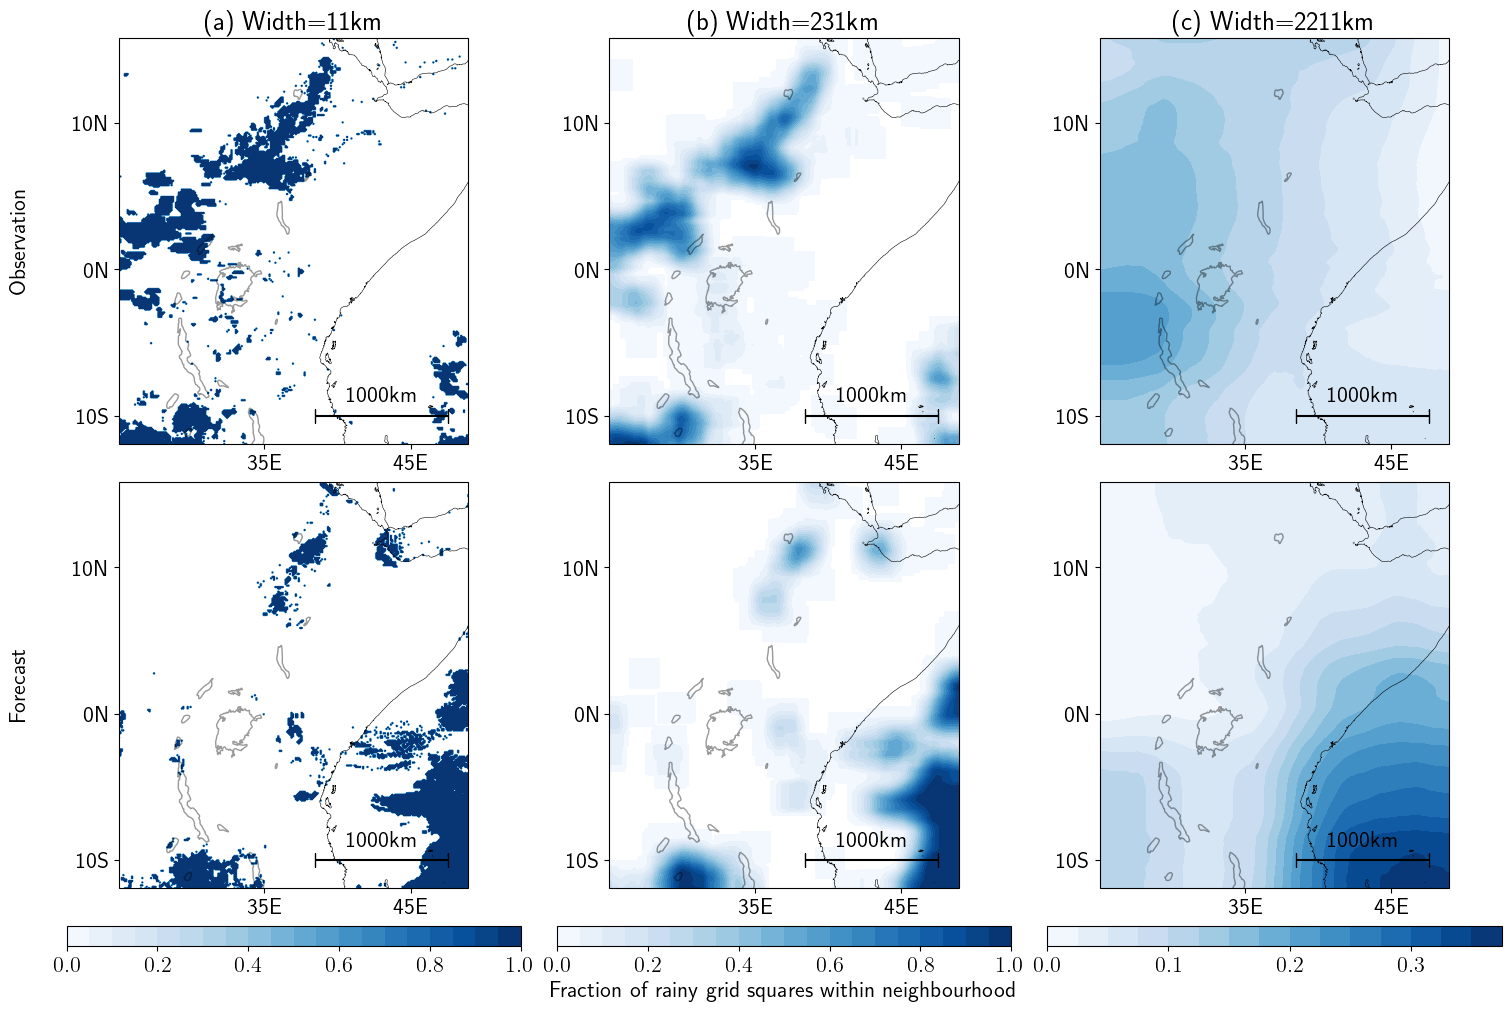

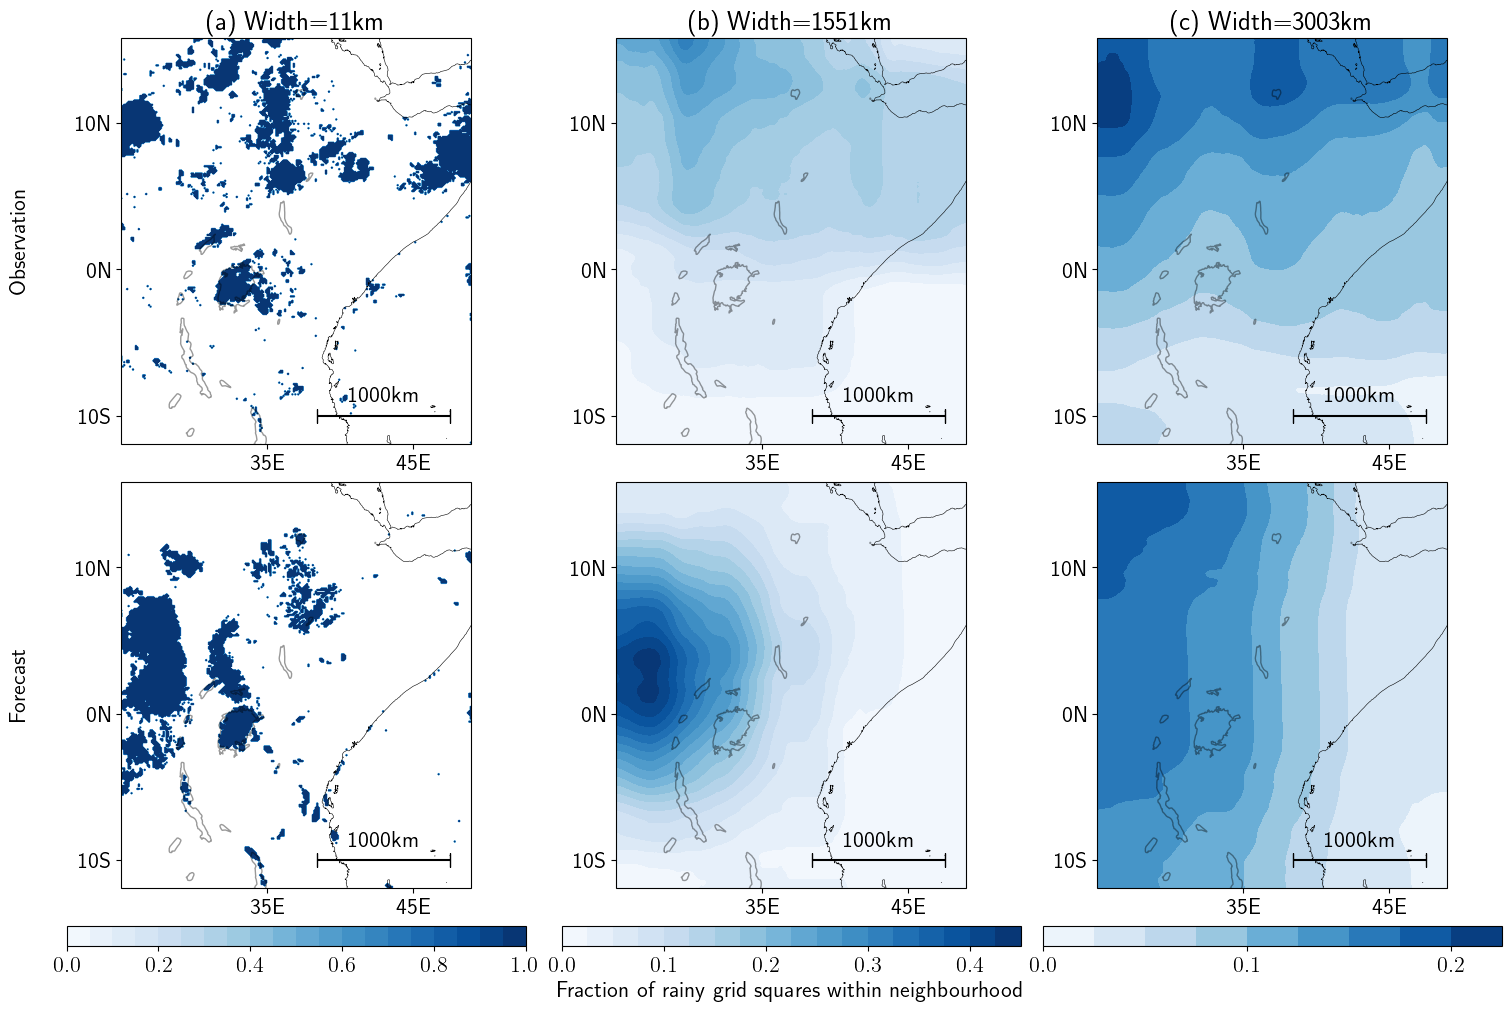

In [24]:

plt.rcParams.update({'font.size': 16})

 
n_vals_lookup = {1: [0, 10, 100],
                 7: [0, 70, 136]}
for ex_no in [1,7]:

    n_vals = n_vals_lookup[ex_no]

    example = examples[ex_no]
    fig = plt.figure(constrained_layout=True, figsize=(15,10))
    gs = gridspec.GridSpec(3, len(n_vals)+1, figure=fig, 
                        height_ratios=[1, 1] + [0.05],
                        width_ratios=[0.02] + [1,1,1],
                        wspace=0.005)  

    month = example['month']
    day = example['day']
    hr_start = example['hr_start']
    hr_end = example['hr_end']
    year_of_data = 2019
    mode = 'reflect'


    for m, n_val in enumerate(n_vals):
        ax_obs = fig.add_subplot(gs[0, m+1], projection = ccrs.PlateCarree())
        ax_fcst = fig.add_subplot(gs[1, m+1], projection = ccrs.PlateCarree())
        
        width = (2*n_val + 1)

        threshold_percentile = 90
        threshold_obs= np.percentile(example['obs'].flatten(), threshold_percentile)
        threshold_fcst = np.percentile(example['forecast'].flatten(), threshold_percentile)

        smoothed_obs = get_convolved_fractions(example['obs'], threshold=threshold_obs, scale=width, mode=mode)
        smoothed_fcst = get_convolved_fractions(example['forecast'], threshold=threshold_fcst, scale=width, mode=mode)

        mu_o = smoothed_obs.mean()
        mu_f = smoothed_fcst.mean()

        sigma_o = smoothed_obs.std()
        sigma_f = smoothed_fcst.std()

        max_val = np.round(max(smoothed_obs[0,:,:].max(), smoothed_fcst[0,:,:].max()), 2)

        if max_val > 0.9:
            step_size = 0.2
        elif max_val < 0.2:
            step_size = 0.05
        else:
            step_size = 0.1

        val_range = [item for item in  np.arange(0,1+step_size,step_size/4) if item < max_val]
        if val_range[-1] != 1:
            val_range = val_range + [np.arange(0,1+step_size,step_size/4)[len(val_range)]]

        ticks = [item for item in  np.arange(0,val_range[-1]+0.1,step_size) ]

        smoothed_obs[0,:,:][smoothed_obs[0,:,:] ==0] = -0.1
        smoothed_fcst[0,:,:][smoothed_fcst[0,:,:] ==0] = -0.1
        im0 = plot_contourf(ax=ax_obs, data=smoothed_obs[0,:,:], title=f'({ascii_lowercase[m]}) Width={width*11}km', lon_range=longitude_range, 
                            lat_range=latitude_range, cmap='Blues', value_range=val_range, extend='neither')
        im1 = plot_contourf(ax=ax_fcst, data=smoothed_fcst[0,:,:], title=f'', lon_range=longitude_range, lat_range=latitude_range, 
                            cmap='Blues', value_range=val_range, extend='neither')
        
        lon_ticks = np.arange(25, 50,10)
        lat_ticks = np.arange(-10, 15,10)
        for a in [ax_fcst, ax_obs]:
            a.set_xticks(lon_ticks)
            a.set_yticks(lat_ticks)
            a.set_xticklabels([f'{ln}E' for ln in lon_ticks])
            a.set_yticklabels([f"{np.abs(lt)}{'N' if lt >=0 else 'S'}" for lt in lat_ticks])

            a.errorbar( 43, -10, xerr=50.0/11, color='k', capsize=5)
            a.text(  43, -8, '1000km',  horizontalalignment='center', verticalalignment='top')

        cbar_ax = fig.add_subplot(gs[-1, m+1])
        if m ==1:
            cb_label = 'Fraction of rainy grid squares within neighbourhood'
        else:
            cb_label = ''
        cb0 = fig.colorbar(im0, cax=cbar_ax, orientation='horizontal', 
                        shrink = 0.2, aspect=8, ticks=ticks, label=cb_label)
    dummy_ax_obs = fig.add_subplot(gs[0, 0])
    dummy_ax_fcst = fig.add_subplot(gs[1, 0])

    dummy_ax_obs.set_frame_on(False)
    dummy_ax_obs.set_ylabel('Observation')
    dummy_ax_obs.set_xticks([])
    dummy_ax_obs.set_yticks([])

    dummy_ax_fcst.set_frame_on(False)
    dummy_ax_fcst.set_ylabel('Forecast')
    dummy_ax_fcst.set_xticks([])
    dummy_ax_fcst.set_yticks([])


    plt.savefig(f'blurring_{month}_{day}_{year_of_data}_hr{hr_start}-{hr_end}_thr{threshold_percentile}_mode{mode}.pdf', format='pdf', bbox_inches = 'tight')

